# Overview

This tutorial showcases the utilities contained in the rings subpackage of pylanetary. Learn how to use the Ring, RingSystemModelObservation 

In [1]:
from pylanetary.rings import *
import matplotlib.pyplot as plt
from matplotlib import cm
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import EarthLocation
from astropy.io import fits
from astroquery.jplhorizons import Horizons
from datetime import datetime, timedelta
import numpy as np
from pylanetary.utils import convolve_with_beam

# Making a single/basic model ring

In [2]:
a = 51149 #km
e = 0.5
i = 80.0
omega = 60.0
w = 30.
imsize = 300 #px
pixscale = 500 #km/px

In [3]:
ringmodel = Ring(a, e, omega, i, w)
img = ringmodel.as_2d_array((imsize, imsize), pixscale) #shape (pixels), pixscale (km)

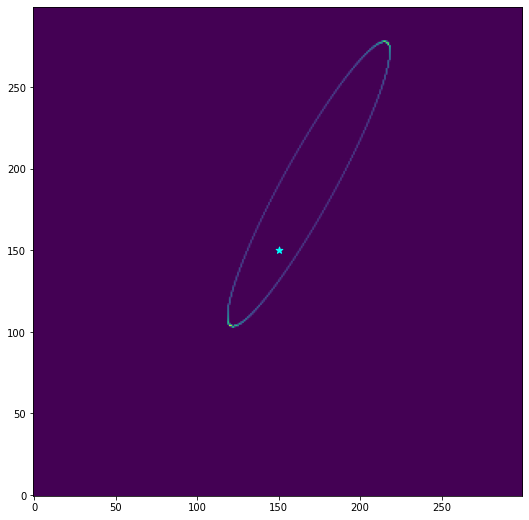

In [4]:
fig, ax = plt.subplots(1,1, figsize = (9,9))

ax.imshow(img, origin = 'lower')
ax.scatter([imsize/2],[imsize/2], color = 'cyan', marker = '*', s = 50, label = 'center of Uranus')

plt.savefig('example_epsilon_ring.png')
plt.show()

## giving rings width and brightness

of course, real rings are not infinitesimal mathematical constructs. they have width, and in an astronomical context, they also have surface brightness. Note here that we can also modify the ring properties in place, but we must specify Astropy units when doing so.

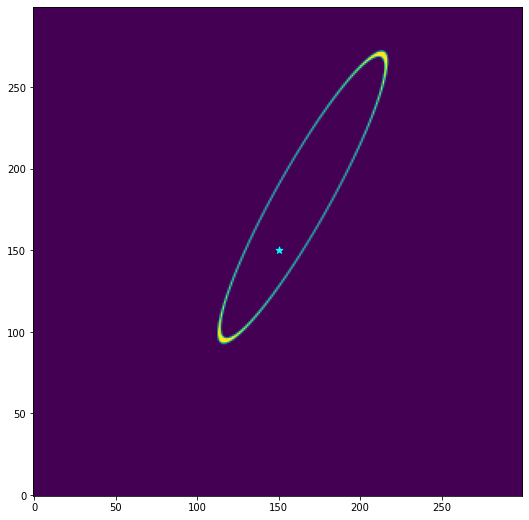

In [5]:
# to do: add a colorbar here!
ringmodel2 = Ring(a, 0.01, omega, i, w, flux = 0.001, width = 500)
ringmodel2.e = 0.4
ringmodel2.width = 2000*u.km
img = ringmodel2.as_2d_array((imsize, imsize), pixscale) #shape (pixels), pixscale (km)
fig, ax = plt.subplots(1,1, figsize = (9,9))

ax.imshow(img, origin = 'lower')
ax.scatter([imsize/2],[imsize/2], color = 'cyan', marker = '*', s = 50, label = 'center of Uranus')
plt.savefig('example_epsilon_ring.png')
plt.show()

## using ring objects as masks

suppose we wanted to extract the flux from a real image in an annulus defined by the ring above. this is easily done, because under the hood, these rings are photutils.EllipticalAnnulus objects. We can simply say,

In [6]:
ann = ringmodel2.as_elliptical_annulus((imsize, imsize), pixscale)
print(type(ann))

<class 'photutils.aperture.ellipse.EllipticalAnnulus'>


See below for an example that uses these aperture masks on real data

## convolving with a beam

we can also define an elliptical beam to convolve with as we cast into a 2-D array

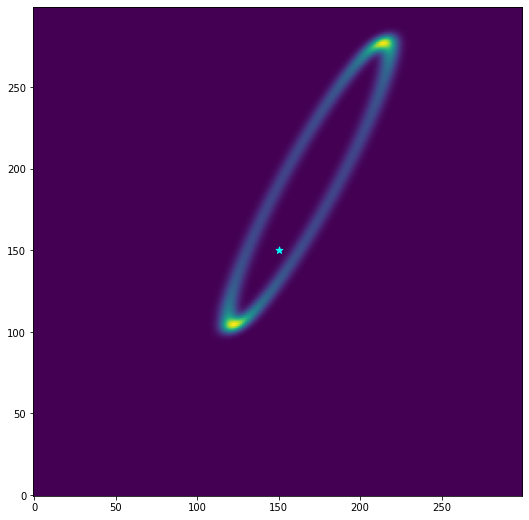

In [7]:
img = ringmodel.as_2d_array((imsize, imsize), pixscale, beamsize = (10,6,30))

fig, ax = plt.subplots(1,1, figsize = (9,9))

ax.imshow(img, origin = 'lower')
ax.scatter([imsize/2],[imsize/2], color = 'cyan', marker = '*', s = 50, label = 'center of Uranus')
plt.savefig('example_epsilon_ring.png')
plt.show()

# Model ring system observation

the RingSystemModelObservation tool makes mock observations of rings. It contains a static data table of ring properties for Jupiter, Saturn, Uranus, and Neptune. It interfaces with the Planetary Ring Node query tool and the JPL Horizons query tool to make the proper projected geometry for a given time of observation. The end result is basically a fully-editable Python version of the Planetary Ring Node.  Here is an example of a simple query:

In [8]:
epoch = '2020-01-30 00:00'
alma_coords = ( -67.755 * u.deg, -23.029 * u.deg, 5000 * u.m) #lon, lat, alt(m)
ringnames = ['Six', 'Five', 'Four', 'Alpha', 'Beta', 'Eta', 'Gamma', 'Delta', 'Epsilon']

In [9]:
from pylanetary.rings import RingSystemModelObservation
epoch_astropy = Time(epoch, format = 'iso', scale = 'utc')
alma_coords_astropy = EarthLocation(alma_coords[0], alma_coords[1], alma_coords[2])
    
uranus_rings = RingSystemModelObservation('uranus',
                     epoch=epoch_astropy,
                     location = alma_coords_astropy,
                     ringnames = ringnames)

uranus_rings.ringtable.pprint_all()

  ring  pericenter ascending node Middle Boundary (km) Width Eccentricity Inclination (deg) Optical Depth      Type      Associated Moons Footnotes                          Comments                        
           deg          deg                                                                                                                                                                                  
------- ---------- -------------- -------------------- ----- ------------ ----------------- ------------- ------------- ----------------- --------- ---------------------------------------------------------
    Six      302.5           34.4              41838.0  1.53      0.00102            0.0607           0.3 Narrow, dense                           2                                                          
   Five    259.372          282.6              42234.0  2.28       0.0019            0.0559           0.5 Narrow, dense                           2                             

The model observation has made Ring objects for each ring in ringnames. All the properties of Ring objects discussed above can be used here. Let's go ahead and plot the full model

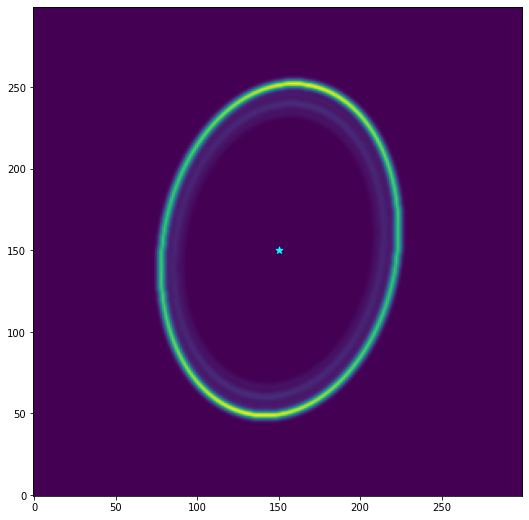

In [10]:
obs = uranus_rings.as_2d_array((imsize, imsize), pixscale, beamsize = (4,4,30)) 
fig, ax = plt.subplots(1,1, figsize = (9,9))

ax.imshow(obs, origin = 'lower')
ax.scatter([imsize/2],[imsize/2], color = 'cyan', marker = '*', s = 50, label = 'center of Uranus')
plt.show() 

Notice that we do not need to specify an image size or pixel scale until we have decided to cast the system into an array. This gives us more flexibility to modify things before plotting or comparing to observations

## modifying the defaults

sometimes we want something other than the default values for radius, eccentricity, etc., or to play with different ephemerides. In this case, we can simply modify the Ring objects directly before plotting.  Let's make the epsilon ring larger, and the alpha ring more eccentric

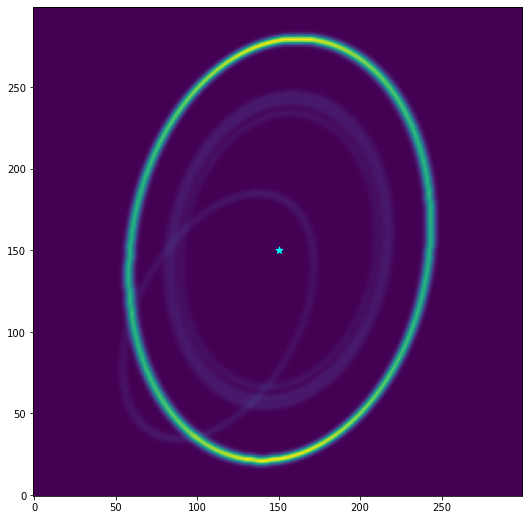

In [11]:
uranus_rings.rings['Epsilon'].a = 65000*u.km
uranus_rings.rings['Alpha'].e = 0.7
uranus_rings.rings['Alpha'].omega = 120*u.deg
obs = uranus_rings.as_2d_array((imsize, imsize), pixscale, beamsize = (5,4,30)) 
fig, ax = plt.subplots(1,1, figsize = (9,9))

ax.imshow(obs, origin = 'lower')
ax.scatter([imsize/2],[imsize/2], color = 'cyan', marker = '*', s = 50, label = 'center of Uranus')
plt.show() 

## support for minor rings

The static data tables loaded from the PDS support minor rings and dusty rings, too.

Ring instance; a=39600.0 km, e=0.0, i=0.0 deg, omega=0.0 deg, w=0.0 deg, width=3500.0 km


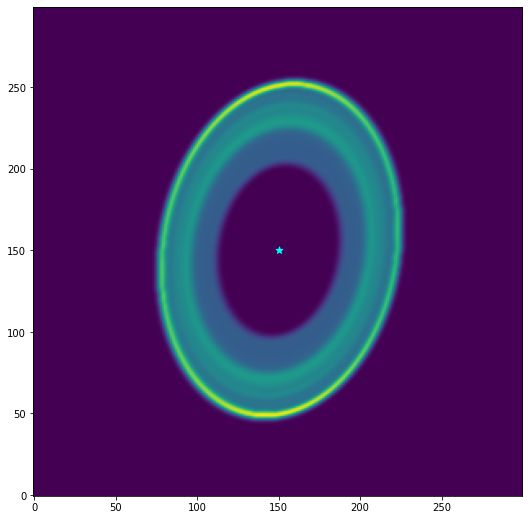

In [12]:
epoch_astropy = Time(epoch, format = 'iso', scale = 'utc')
alma_coords_astropy = EarthLocation(alma_coords[0], alma_coords[1], alma_coords[2])
    
uranus_rings_dusty = RingSystemModelObservation('uranus',
                     epoch=epoch_astropy,
                     location = alma_coords_astropy,
                     ringnames = None)

print(uranus_rings_dusty.rings['Zeta'])

obs = uranus_rings_dusty.as_2d_array((imsize, imsize), pixscale, beamsize = (5,4,30)) 

fig, ax = plt.subplots(1,1, figsize = (9,9))

ax.imshow(obs, origin = 'lower')
ax.scatter([imsize/2],[imsize/2], color = 'cyan', marker = '*', s = 50, label = 'center of Uranus')
plt.show() 

## modifying widths and fluxes

This image shows some weaknesses of the default behavior: for minor rings, the relative brightnesses and/or widths are very often incorrect due to a lack of good data. We can get around this either by modifying each Ring object after instantiating them, or by inputting a list of fluxes and/or widths as we instantiate the model. See the documentation of Ring, Ring.as_2d_array, and Ring.as_elliptical_annulus

# Analysis with real data

Here, these tools are applied to real Keck K-band data. We extract the radial profiles of the ring system and the azimuthal profile of the epsilon ring.

## Import Keck data, then make a model at the same datetime

In [13]:


hdul = fits.open('data/urk140.fits') #urh60.fits
pixscale_arcsec = 0.009942 #arcsec, keck
keck_coords = (360*u.deg - 155.4744 * u.deg, 19.8264 * u.deg, 4145 * u.m) #lon (East), lat, alt(m)

header = hdul[0].header
data = hdul[0].data
obs_time = header['DATE-OBS'] + ' ' + header['EXPSTART'][:-4]
print(obs_time)
start_time = datetime.strptime(obs_time, '%Y-%m-%d %H:%M:%S')
end_time = start_time + timedelta(minutes=1)
epochs = {'start':obs_time, 'stop':end_time.strftime('%Y-%m-%d %H:%M:%S'), 'step':'1m'}
keck_coords_astropy = EarthLocation(keck_coords[0], keck_coords[1], keck_coords[2])


# convert pixscale from arcsec to km
obj = Horizons(id='799', location='568', epochs=epochs) #Uranus, Keck
d_AU = obj.ephemerides()['delta'][0]*u.au
dist = d_AU.to(u.km).value
pixscale = dist*np.tan(np.deg2rad(pixscale_arcsec/3600.))
print(f'pixel scale is {pixscale} km')

# image size also from header
imsize = header['NAXIS1']

2019-10-28 12:07:56
pixel scale is 135.79696138751703 km


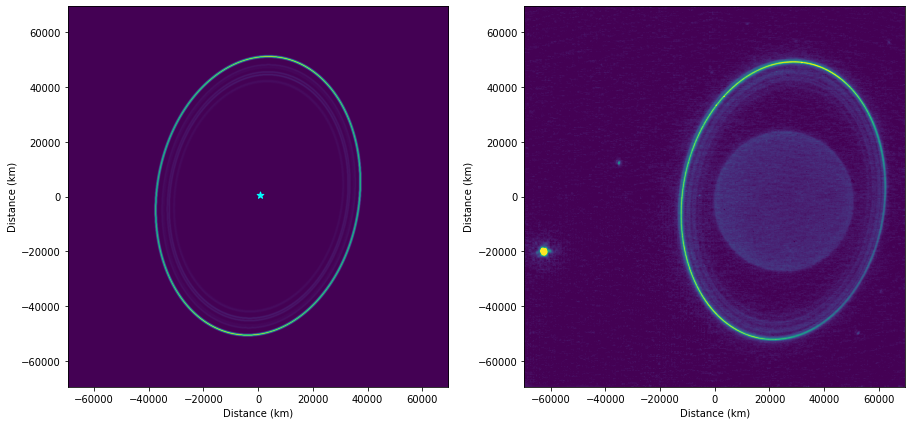

In [14]:
# make the model observation
uranus_rings = RingSystemModelObservation('uranus',
                     epoch=Time(start_time, scale='utc'),
                     location = keck_coords_astropy,
                     ringnames = ringnames)
model_keck_obs = uranus_rings.as_2d_array((imsize, imsize), pixscale, beamsize = 4.0) 

sz = pixscale*imsize
fig, [ax0, ax1] = plt.subplots(1,2, figsize = (15,10))

ax0.imshow(model_keck_obs, origin = 'lower', extent=[-sz/2, sz/2, -sz/2, sz/2])
ax0.scatter([imsize/2],[imsize/2], color = 'cyan', marker = '*', s = 50, label = 'center of Uranus')

ax1.imshow(data, origin = 'lower', extent=[-sz/2, sz/2, -sz/2, sz/2], vmin=0, vmax = np.max(data)/16)

for ax in [ax0, ax1]:
    ax.set_xlabel('Distance (km)')
    ax.set_ylabel('Distance (km)')

plt.show()

## Extract total ring flux

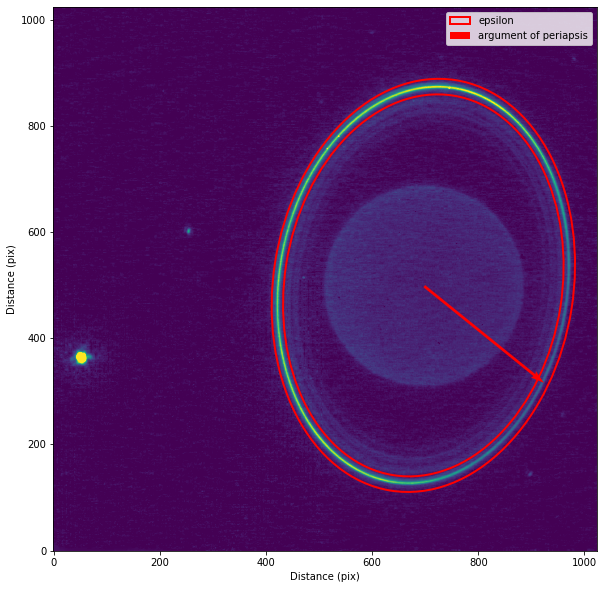

       mean             median       ...        var                sum        
----------------- ------------------ ... ------------------ ------------------
36.28491801499351 25.131513595581055 ... 1003.9261162083001 1826469.4596068654


In [15]:
# They look to compare well. Now make the epsilon ring model into a photutils annulus
eps = uranus_rings.rings['Epsilon']
width = 4000*u.km
focus = np.array([25300, -1900])
focus = focus / pixscale + [imsize/2, imsize/2]
ann, params = eps.as_elliptical_annulus(focus, pixscale, width = width, return_params = True)

avec = params['a'][:2]/(pixscale)
#bvec = params['b'][:2]/(pixscale)
peri = -avec

vmax = np.max(data)
sz = pixscale*imsize
fig, ax = plt.subplots(1,1, figsize = (10,10))

ax.imshow(data, origin = 'lower', vmin = 0, vmax = vmax/16)#, extent=[-sz/2, sz/2, -sz/2, sz/2])
ann_patches = ann.plot(color='red', lw=2, label='epsilon')

ax.quiver([focus[0]],[focus[1]],[peri[0]],[peri[1]], color='red', angles='xy', scale_units='xy', scale=1, width=0.005, label = 'argument of periapsis')

ax.set_xlabel('Distance (pix)')
ax.set_ylabel('Distance (pix)')
ax.legend()

plt.show()

# extract flux from epsilon ring (arbitrary units)
from photutils.aperture import ApertureStats
stats = ApertureStats(data, ann)
print(stats.to_table(['mean', 'median', 'std', 'var', 'sum']))

It is worth noting that this measurement does not represent the "true" total flux of the epsilon ring because this aperture both (1) contains flux from other rings and (2) misses flux in the sidelobes of the PSF. Better practice would be to fit a ring model to the data in one or two dimensions.

## Radial profile of the ring system

/var/folders/g0/r491pzqx4kx0tfmpx8970ntm0000gn/T/ipykernel_76005/1587455419.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks()/1000)


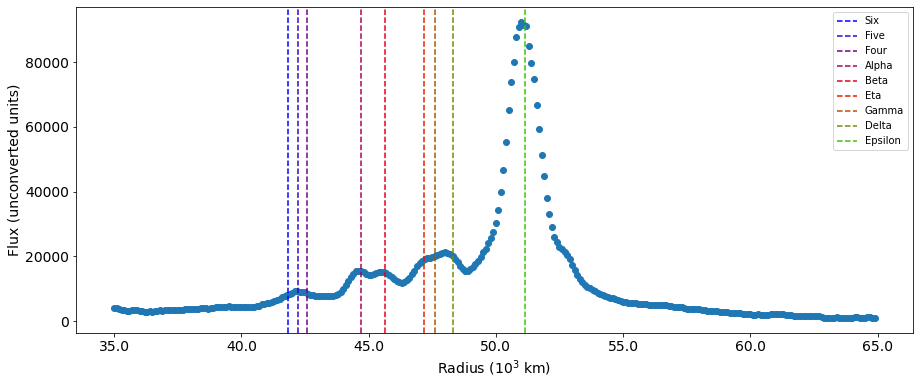

In [16]:
### Make the radial profile
r_in = 35000 #km
r_out = 65000 #km
r_step = 100 #km

# extract radial profile by hijacking ring plane orientation from epsilon ring system params
eps = uranus_rings.rings['Epsilon']
zeroe_ring = Ring(eps.a, 0.0, eps.params_sys[1], eps.params_sys[0], eps.params_sys[2])
radii = np.arange(r_in, r_out, r_step)
sums = np.empty(radii.shape)
for i,r in enumerate(radii):
    zeroe_ring.a = r * u.km
    ann = zeroe_ring.as_elliptical_annulus(focus, pixscale, width = r_step*u.km, return_params = False)
    stats = ApertureStats(data, ann, sum_method = 'subpixel')
    sums[i] = stats.sum

    
# plot it
fs = 14
fig, ax = plt.subplots(1,1,figsize=(15,6))
cmap = cm.brg

# get ring expected semimajor axes from static data, plot them
for i, ringname in enumerate(ringnames):
    single_ring = uranus_rings.rings[ringname]
    ax.axvline(single_ring.a.value, color=cmap(i/len(ringnames)), linestyle = '--', label = ringname)
ax.scatter(radii, sums)
ax.set_xticklabels(ax.get_xticks()/1000)
ax.tick_params(which='both', labelsize = fs)
ax.set_xlabel(r'Radius (10$^3$ km)', fontsize = fs)
ax.set_ylabel('Flux (unconverted units)', fontsize = fs)
ax.legend()

plt.show()

## Azimuthal profile of epsilon ring

In [17]:
nwedges = 30
thetas_implane, wedges = eps.as_azimuthal_wedges([imsize,imsize], pixscale, focus=focus, nwedges=nwedges, z=1, width = width)

wedge_sums = []
data_sums = []
extraction_region = np.zeros(data.shape)
for i, wedge in enumerate(wedges):
    
    wedge_data = data * wedge
    extraction_region += wedge_data
    data_sums.append(np.nansum(wedge_data))
    wedge_sums.append(np.nansum(wedge))
    
    
    ## diagnostic plot: if working right, this will show a small wedge of ring data
    #if i == 5:
    #    plt.imshow(wedge_data, origin='lower')
    #    plt.show()
        
wedge_sums = np.array(wedge_sums)
data_sums = np.array(data_sums)

## diagnostic plot: if working right, this will show the data within the extraction region only, 
## i.e. the sum of all the wedges
# fig, ax = plt.subplots(1,1, figsize = (12,12))
# ax.imshow(extraction_region, origin = 'lower')
# plt.show()

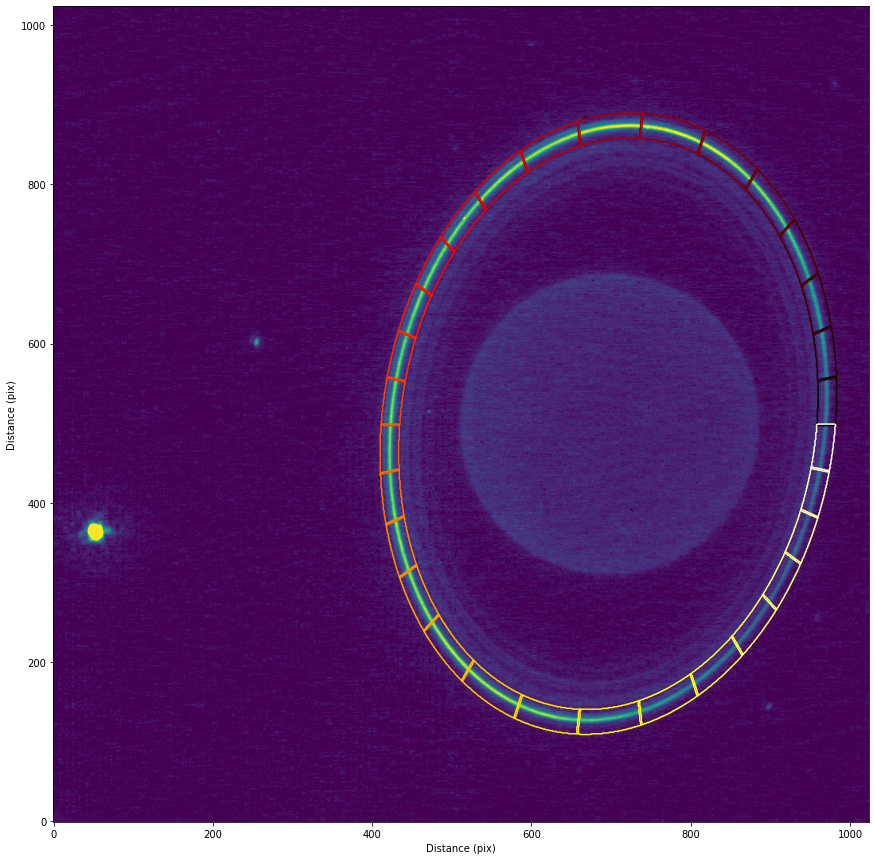

In [18]:
from matplotlib import cm
cmap = cm.hot
fig, ax = plt.subplots(1,1, figsize = (15,15))

ax.imshow(data, origin = 'lower', vmin=0, vmax = vmax/16)#, extent=[-sz/2, sz/2, -sz/2, sz/2])
for i, wedge in enumerate(wedges):
    
    theta = thetas_implane[i]
    color = cmap(theta/(2*np.pi))
    
    ax.contour(wedge, levels=[0.01], colors=[color])

ax.set_xlabel('Distance (pix)')
ax.set_ylabel('Distance (pix)')

plt.show()

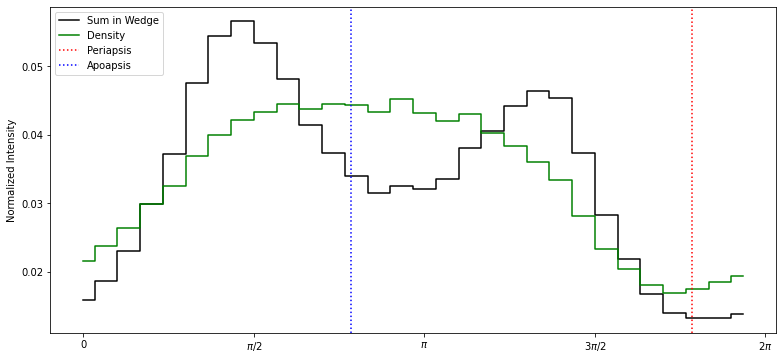

In [19]:
# find periapsis and apoapsis angle
peri_angle = np.arctan2(peri[1], peri[0])%(2*np.pi)
apo_angle = (peri_angle + np.pi)%(2*np.pi)

fig, ax = plt.subplots(1,1, figsize = (13,6))

ax.step(thetas_implane, data_sums/np.sum(data_sums), color='k', label='Sum in Wedge', where='mid')
ax.step(thetas_implane, (data_sums/wedge_sums)/np.sum((data_sums/wedge_sums)), color='green', label = 'Density', where='mid')
#ax0.set_xlabel('Theta (rad)')
ax.set_ylabel('Normalized Intensity')
                        

ax.axvline(peri_angle, color = 'red', linestyle = ':', label='Periapsis')
ax.axvline(apo_angle, color = 'blue', linestyle = ':', label='Apoapsis')
ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
ax.set_xticklabels(['0', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
ax.legend()
#ax2 = ax.twinx()
#ax2.plot(thetas_implane, fsc, color = 'k', linestyle = '--')
#ax2.set_ylabel('Foreshortening Correction')
    

plt.show()

It can be seen that the flux density is roughly at a minimum at periapsis.

To do: why is there an offset between the true minimum and the argument of periapsis? Is this real, or is the geometry still not correct? How can I test this?

### A note on foreshortening

After [de Pater et al. 2006](doi:10.1016/j.icarus.2005.08.011) and others, a geometric correction needs to be applied to a tilted ring to account for the [foreshortening effect](https://i.ytimg.com/vi/25wSIcjY1Bw/maxresdefault.jpg).  However, this correction is not necessary here, because the wedges we use for extraction are themselves foreshortened, and the code calculates their "true" areas accordingly. 

The perfect data experiment below shows evidence that this is really true.

In [20]:
def foreshortening(theta, i):
    '''
    from de Pater et al 2006, doi:10.1016/j.icarus.2005.08.011
    
    i: degrees
    theta: radians
        (deal with it)
    '''
    B = np.pi/2 - np.abs(np.deg2rad(i))
    return np.sqrt( np.sin(theta)**2 * np.sin(B)**2 + np.cos(theta)**2 )

In [21]:
# perfect data experiment for foreshortening
a = 51149 #km
e = 0.6
i = 60.0
omega = 60.0
w = 30.

imsize = 300
pixscale = 500*u.km
nwedges = 30
width = 5000*u.km
focus = np.array([imsize/2,imsize/2])
ringmodel = Ring(a, e, omega, i, w)
data = ringmodel.as_2d_array((imsize, imsize), pixscale, beamsize=(2,2,0)) #shape (pixels), pixscale (km)

In [22]:
thetas, wedges = ringmodel.as_azimuthal_wedges((imsize,imsize), pixscale, focus=focus, nwedges=nwedges, z=1, width = width)
fsc= foreshortening(thetas, i)

wedge_sums = []
data_sums = []
extraction_region = np.zeros(data.shape)
for i, wedge in enumerate(wedges):
    
    wedge_data = data * wedge
    extraction_region += wedge_data
    data_sums.append(np.nansum(wedge_data))
    wedge_sums.append(np.nansum(wedge))
        
wedge_sums = np.array(wedge_sums)
data_sums = np.array(data_sums)

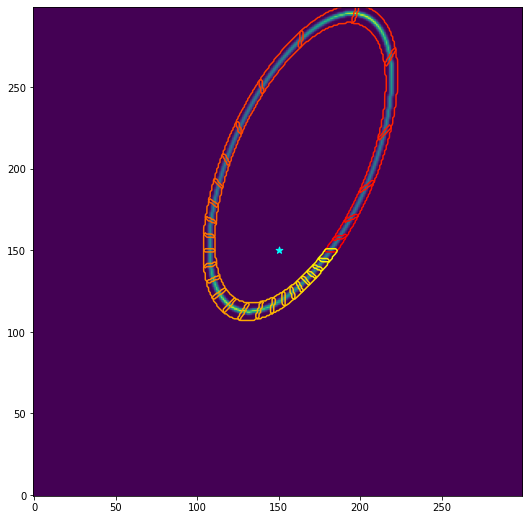

In [23]:
cmap = cm.autumn
fig, ax = plt.subplots(1,1, figsize = (9,9))
ax.imshow(data, origin = 'lower')
ax.scatter([imsize/2],[imsize/2], color = 'cyan', marker = '*', s = 50, label = 'center of Uranus')

for i, wedge in enumerate(wedges):
    
    theta = thetas[i]
    color = cmap(theta/(2*np.pi))
    
    ax.contour(wedge, levels=[0.01], colors=[color])



plt.show() 

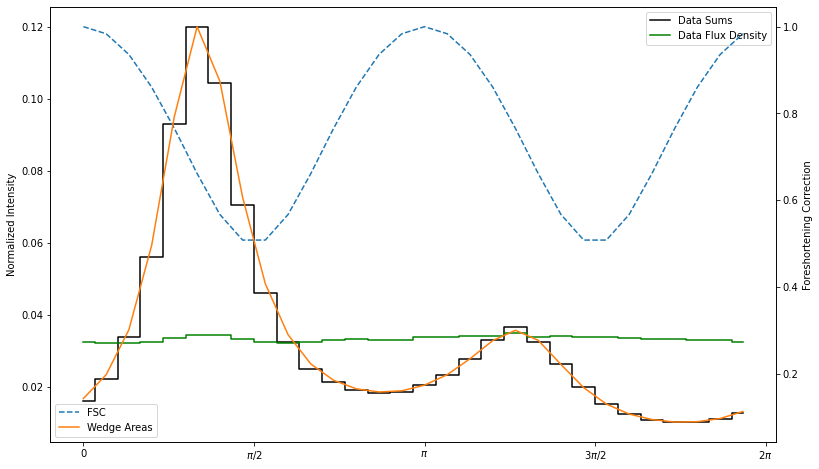

In [24]:
fig, ax = plt.subplots(1,1, figsize = (13,8), sharex=True)

ax.step(thetas, data_sums/np.sum(data_sums), color='k', label='Data Sums', where='mid')
ax.step(thetas, (data_sums/wedge_sums)/np.sum((data_sums/wedge_sums)), color='green', label = 'Data Flux Density', where='mid')
#ax0.set_xlabel('Theta (rad)')
ax.set_ylabel('Normalized Intensity')

ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
ax.set_xticklabels(['0', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
ax.legend()

ax2 = ax.twinx()
ax2.plot(thetas, fsc, linestyle = '--', label='FSC')
ax2.plot(thetas, wedge_sums/np.max(wedge_sums), label='Wedge Areas')
ax2.set_ylabel('Foreshortening Correction')
#ax.legend()
    
plt.legend()
plt.show()

Perfect data experiment result: dividing the extracted sums within each wedge (black steps) by the area of the wedges (orange line) gives us back the uniform-brightness foreshortening-corrected data (green steps).

**It's very important to make the region wide enough to capture all the flux! otherwise, this geometric correction interacts with the PSF to make non-uniform behavior**

# Making a movie of the epsilon ring precession

As a nice example, and just for fun, here is how one would make an animation of the precession of the epsilon ring. I'm bumping the eccentricity of the ring up to 0.2 so you can see it visually; otherwise, this doesn't look like much!

The way I implemented this was to first make an initial model ring at the first time step. I then run many queries to ring node tool, each time saving the argument of periapsis of the epsilon ring. I make those a simple list, and then each time I plot, I just change the value of $\omega$ in the ring model and cast it into a 2-D array.

Note it would be just as easy, and more accurate (but slightly slower) to make a new RingSystemModelObservation for every time step. But the way I implemented it better showcases how a pre-existing ring model can be modified.


In [25]:
from datetime import datetime, timedelta
from astroquery.solarsystem.pds import RingNode
node = RingNode()
epoch_0 = datetime.strptime('2022-09-23 00:00', '%Y-%m-%d %H:%M')
wvals = []
for i in range(100):
    
    epoch = Time(epoch_0 + timedelta(days=5*i), scale='utc')
    bodytable, ringtable = node.ephemeris(planet='Uranus', epoch=epoch, location=alma_coords_astropy, cache=False)
    epsilon = ringtable[ringtable.loc_indices["Epsilon"]]
    w = epsilon['pericenter'].to(u.deg).value
    wvals.append(w)
    
wvals = np.asarray(wvals)
np.save('wvals.npy', wvals)

In [26]:
%%capture
wvals = np.load('wvals.npy')
beam = (4,3,30)

# set up initial state
model0 = RingSystemModelObservation('uranus',
                     epoch=Time(epoch_0, scale='utc'),
                     location = alma_coords_astropy,
                     ringnames = ['Alpha','Epsilon'])
epsilon = model0.rings['Epsilon']
ringmodel = Ring(epsilon.a, 0.2, epsilon.omega, epsilon.i, epsilon.w)
img0 = ringmodel.as_2d_array((imsize, imsize), pixscale, beamsize = beam)

  
# set up the animation
import matplotlib.animation as animation

fig, ax = plt.subplots(1,1, figsize = (9,9))

im = ax.imshow(img0, origin = 'lower')
ax.scatter([img0.shape[0]/2],[img0.shape[1]/2], color = 'cyan', marker = '*', s = 50, label = 'center of Uranus')

# animation function.  This is called sequentially
def animate(i, wvals):
    '''progressively increase w'''
    ringmodel.w = wvals[i]*u.deg
    img = ringmodel.as_2d_array((imsize, imsize), pixscale, beamsize = (10,6,30))
    a=im.get_array()
    a=img 
    im.set_array(a)
    return [im]

anim = animation.FuncAnimation(fig, animate, frames=len(wvals), fargs=(wvals,),
                              interval=100, blit=True)

anim.save('epsilon_precession.gif', fps=30)


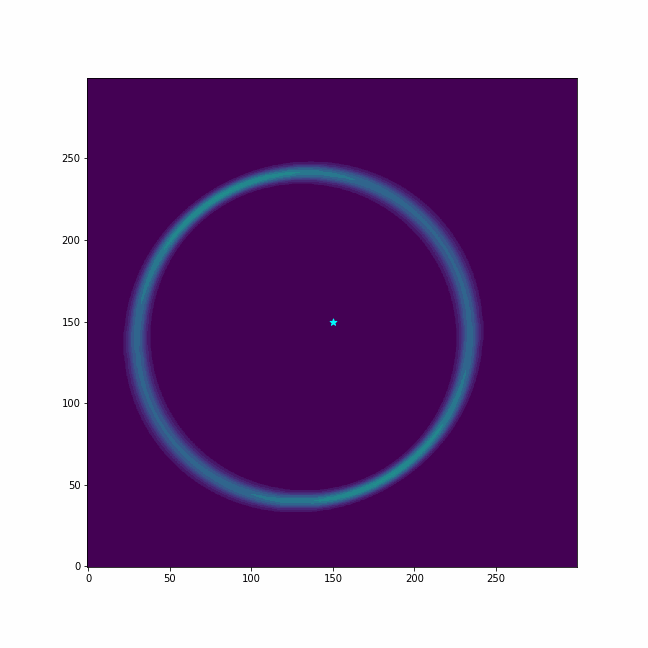

In [27]:
from IPython.display import Image
Image("epsilon_precession.gif", width=600, height=600)

# Loose ends / to-do list

- need support for apoapsis wider than periapsis
- optically thin vs optically thick rings will act differently when foreshortened, especially if the ring is broad. This is not currently accounted for and sort of requires radiative transfer to do properly.
- Ease-of-use of flux density units should be tested; still need to make final decision there